## ML Zoom Camp 2022
### Week 4 assignment

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [137]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [138]:
df = pd.read_csv('../data/AER_credit_card_data.csv')


In [139]:
df.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


In [140]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [141]:
categorical = df.select_dtypes(include="object").columns.tolist()
numerical = df.select_dtypes(exclude="object").columns.tolist()

categorical.remove('card')

## Data Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.


In [142]:
# We make sure here there are no missing values
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [143]:
df.card = df.card.replace(to_replace=['no', 'yes'], value=[0, 1])
df.card

0       1
1       1
2       1
3       1
4       1
       ..
1314    1
1315    0
1316    1
1317    1
1318    1
Name: card, Length: 1319, dtype: int64

## Data Split

In [144]:
SEED = 1

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

assert len(df) == (len(df_train) + len(df_val) + len(df_test))

len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

assert 'card' not in df_train.columns
assert 'card' not in df_val.columns
assert 'card' not in df_test.columns

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- `reports`
- `dependents`
- `active`
- `share`

In [145]:
from sklearn.metrics import roc_auc_score

In [146]:
scores = {}
for feature in numerical:
    score = roc_auc_score(y_train, df_train[feature])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    scores[feature] = score
    print(f'{feature}: {score}')

reports: 0.7166629860689376
age: 0.5240020979407055
income: 0.5908049467233478
share: 0.989183643423692
expenditure: 0.991042345276873
dependents: 0.5327757227773791
months: 0.5294217780967629
majorcards: 0.5343859842838476
active: 0.6043173411362006


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [147]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [148]:
train_dict = df_train[categorical+numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

Always check before continuing

In [149]:
dv.get_feature_names_out()

array(['active', 'age', 'dependents', 'expenditure', 'income',
       'majorcards', 'months', 'owner=no', 'owner=yes', 'reports',
       'selfemp=no', 'selfemp=yes', 'share'], dtype=object)

In [150]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)

val_dict = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_pred),2)
print(accuracy)


0.97


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [151]:
score = roc_auc_score(y_val, y_pred)
print(f'ROC_AUC_score = {round(score, 3)}')

ROC_AUC_score = 0.974


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [152]:
scores = []

thresholds = np.linspace(0, 1, 101)

for thr in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= thr)
    predict_negative = (y_pred < thr)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if (tp + fp > 0):
        p = tp / (tp + fp)
    else:
        p = 1
    r = tp / (tp + fn)

    scores.append((thr, p, r))

In [153]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

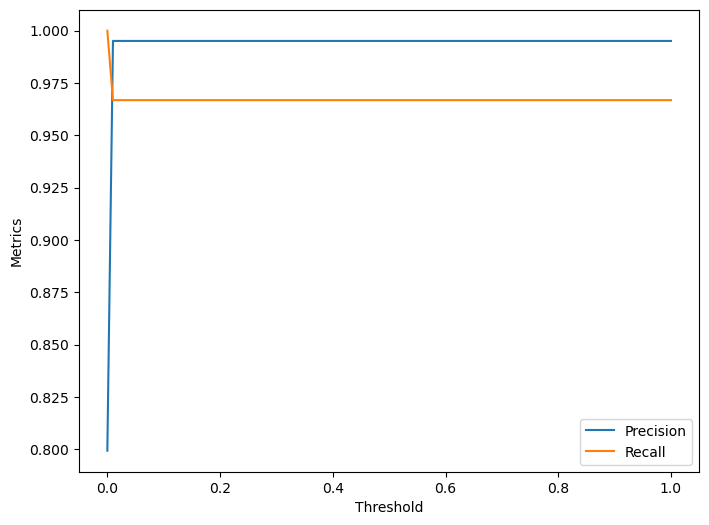

In [154]:
plt.figure(figsize=(8, 6))
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend();

They intersect close to 0, nearest result is at 0.1.

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [155]:
df_scores['f1_score'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])

In [156]:
df_scores.head()

,threshold,precision,recall,f1_score
0,0.00,0.799242,1.000000,0.888421
1,0.01,0.995122,0.966825,0.980769
2,0.02,0.995122,0.966825,0.980769
3,0.03,0.995122,0.966825,0.980769
4,0.04,0.995122,0.966825,0.980769


Text(0, 0.5, 'F1 score')

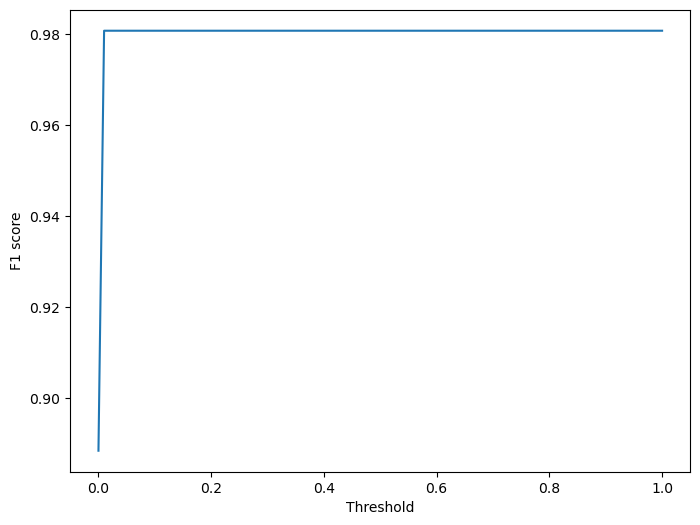

In [157]:
plt.figure(figsize=(8, 6))
plt.plot(df_scores.threshold, df_scores.f1_score, label='F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 score')

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [158]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [159]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical+categorical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [160]:
def predict(df, dv, model):
    dicts = df[numerical+categorical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [162]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.4f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.996 +- 0.0027


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [164]:
n_splits = 5
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C = %s: %.3f +- %.4f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C = 0.01: 0.992 +- 0.0056
C = 0.1: 0.995 +- 0.0040
C = 1: 0.996 +- 0.0027
C = 10: 0.996 +- 0.0028
